<a href="https://colab.research.google.com/github/pengfei123xiao/ML_Basic/blob/master/models/Ch05-DecisionTree/XGBoost/1/1_Mushroom%2Bskearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## XGBoost+sklearn

In [0]:
from xgboost import XGBClassifier
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from matplotlib import pyplot

### load data

scikit-learn支持多种格式的数据，包括LibSVM格式数据
XGBoost可以加载libsvm格式的文本数据，libsvm的文件格式（稀疏特征）如下：
1 101:1.2 102:0.03
0 1:2.1 10001:300 10002:400
...

每一行表示一个样本，第一行的开头的“1”是样本的标签。“101”和“102”为特征索引，'1.2'和'0.03' 为特征的值。
在两类分类中，用“1”表示正样本，用“0” 表示负样本。也支持[0,1]表示概率用来做标签，表示为正样本的概率。

下面的示例数据需要我们通过一些蘑菇的若干属性判断这个品种是否有毒。
UCI数据描述：http://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/ ，
每个样本描述了蘑菇的22个属性，比如形状、气味等等(加工成libsvm格式后变成了126维特征)，
然后给出了这个蘑菇是否可食用。其中6513个样本做训练，1611个样本做测试。

XGBoost加载的数据存储在对象DMatrix中
XGBoost自定义了一个数据矩阵类DMatrix，优化了存储和运算速度
DMatrix文档：http://xgboost.readthedocs.io/en/latest/python/python_api.html

In [3]:
# read in data
my_workpath = './data/'
# X_train,y_train = load_svmlight_file(my_workpath + 'agaricus.txt.train')
# X_test,y_test = load_svmlight_file(my_workpath + 'agaricus.txt.test')

X_train,y_train = load_svmlight_file('agaricus.txt.train')
X_test,y_test = load_svmlight_file('agaricus.txt.test')
print(X_train.shape)
print(X_test.shape)

(6513, 126)
(1611, 126)


### train_test_split

In [4]:
# split data into train and test sets
seed = 7
test_size = 0.33
X_train_part, X_validate, y_train_part, y_validate= train_test_split(X_train, y_train, test_size=test_size,
    random_state=seed)

print(X_train_part.shape)
print(X_validate.shape)

(4363, 126)
(2150, 126)


### params setting
max_depth： 树的最大深度。缺省值为6，取值范围为：[1,∞] eta：为了防止过拟合，更新过程中用到的收缩步长。在每次提升计算之后，算法会直接获得新特征的权重。 eta通过缩减特征的权重使提升计算过程更加保守。缺省值为0.3，取值范围为：[0,1] silent：取0时表示打印出运行时信息，取1时表示以缄默方式运行，不打印运行时信息。缺省值为0 objective： 定义学习任务及相应的学习目标，“binary:logistic” 表示二分类的逻辑回归问题，输出为概率。

其他参数取默认值

In [5]:
# specify parameters via map
params = {'max_depth':2, 'eta':1, 'silent':0, 'objective':'binary:logistic' }
print(params)

{'max_depth': 2, 'eta': 1, 'silent': 0, 'objective': 'binary:logistic'}


### build models

In [0]:
# 设置boosting迭代计算次数
num_round = 100
#num_round = range(1, 101)
#param_grid = dict(n_estimators=num_round)

#bst = XGBClassifier(params)
bst =XGBClassifier(max_depth=2, learning_rate=0.1,n_estimators=num_round, 
                   silent=True, objective='binary:logistic')

In [11]:
# training
eval_set = [(X_train_part, y_train_part), (X_validate, y_validate)]
bst.fit(X_train_part, y_train_part, early_stopping_rounds=15, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)

[0]	validation_0-error:0.045611	validation_0-logloss:0.614637	validation_1-error:0.048372	validation_1-logloss:0.615401
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 15 rounds.
[1]	validation_0-error:0.041256	validation_0-logloss:0.549907	validation_1-error:0.042326	validation_1-logloss:0.550696
[2]	validation_0-error:0.045611	validation_0-logloss:0.49543	validation_1-error:0.048372	validation_1-logloss:0.496777
[3]	validation_0-error:0.041256	validation_0-logloss:0.449089	validation_1-error:0.042326	validation_1-logloss:0.450412
[4]	validation_0-error:0.041256	validation_0-logloss:0.409231	validation_1-error:0.042326	validation_1-logloss:0.410717
[5]	validation_0-error:0.041256	validation_0-logloss:0.373748	validation_1-error:0.042326	validation_1-logloss:0.375653
[6]	validation_0-error:0.023378	validation_0-logloss:0.343051	validation_1-error:0.023256	validation_1-logloss:0.344

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=True, subsample=1, verbosity=1)

模型在每次校验集上的性能存在模型中，可用来进一步进行分析 model.evals result() 返回一个字典：评估数据集和分数

#### Learning Curve

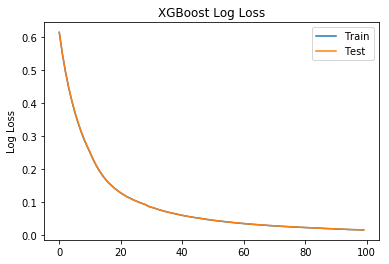

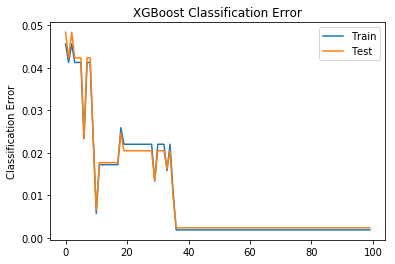

In [13]:
# retrieve performance metrics
results = bst.evals_result()
#print(results)

epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()

# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

XGBoost预测的输出是概率，输出值是样本为第一类的概率。我们需要将概率值转换为0或1。

In [14]:
# make prediction
preds = bst.predict(X_test)
predictions = [round(value) for value in preds]

test_accuracy = accuracy_score(y_test, predictions)
print("Test Accuracy: %.2f%%" % (test_accuracy * 100.0))

Test Accuracy: 99.81%


### KFold CV

In [8]:
# stratified k-fold cross validation evaluation of xgboost model
#kfold = KFold(n_splits=10, random_state=7)
kfold = StratifiedKFold(n_splits=10, random_state=7)
#fit_params = {'eval_metric':"logloss"}
#results = cross_val_score(bst, X_train, y_train, cv=kfold, fit_params)
results = cross_val_score(bst, X_train, y_train, cv=kfold)
print(results)
print("CV Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

[1.         1.         0.99846626 1.         0.99231951 0.9969278
 1.         1.         0.94470046 0.9984639 ]
CV Accuracy: 99.31% (1.63%)


### GridSearch CV

In [9]:
# 设置boosting迭代计算次数
param_test = {
 'n_estimators': range(1, 51, 2)
}
clf = GridSearchCV(estimator = bst, param_grid = param_test, scoring='accuracy', cv=5)
clf.fit(X_train, y_train)
print(clf.cv_results_)
print(clf.best_params_)
print(clf.best_score_)

{'mean_fit_time': array([0.05014801, 0.05491161, 0.06279054, 0.06556134, 0.07101688,
       0.07558894, 0.08296404, 0.0849123 , 0.09430494, 0.09832277,
       0.10342889, 0.10593419, 0.11574636, 0.11983271, 0.12161183,
       0.1293138 , 0.13682241, 0.13994184, 0.14528494, 0.1510622 ,
       0.15995107, 0.1605432 , 0.16513462, 0.17253556, 0.18047833]), 'std_fit_time': array([0.00140967, 0.00153526, 0.00639187, 0.00346525, 0.00255416,
       0.00034682, 0.00404638, 0.000671  , 0.0068852 , 0.0007681 ,
       0.00307043, 0.00073445, 0.0061223 , 0.00468933, 0.00123494,
       0.00223805, 0.00561143, 0.00247218, 0.00118624, 0.00317828,
       0.00589245, 0.00361355, 0.00091462, 0.00355721, 0.00556904]), 'mean_score_time': array([0.01055059, 0.01159039, 0.01189957, 0.01056447, 0.01147585,
       0.01074047, 0.01069932, 0.01064572, 0.01078649, 0.01079788,
       0.0108376 , 0.01063104, 0.01067457, 0.01084852, 0.01055903,
       0.01151848, 0.01064897, 0.01047034, 0.01227784, 0.01068492,
     

In [10]:
# make prediction
preds = clf.predict(X_test)
predictions = [round(value) for value in preds]

test_accuracy = accuracy_score(y_test, predictions)
print("Test Accuracy of gridsearchcv: %.2f%%" % (test_accuracy * 100.0))

Test Accuracy of gridsearchcv: 97.27%
